In [1]:
import shap
import lime
import pandas as pd

from imblearn.pipeline import Pipeline  # Import Pipeline from imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer

seed = 1441

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train = pd.read_csv("../data/train_model.csv")
test = pd.read_csv("../data/test_model.csv")

In [3]:
train.shape

(246008, 23)

In [4]:
train = train.drop(columns='Unnamed: 0')
test = test.drop(columns='Unnamed: 0')


In [5]:
X_train = train.drop(columns=['TARGET'])
y_train = train['TARGET']

In [6]:
X_test = test.drop(columns=['TARGET'])
y_test = test['TARGET']

In [7]:
shap.initjs()

In [10]:
from lightgbm import LGBMClassifier

In [13]:
rus = RandomUnderSampler(random_state=seed)

# Definir el modelo LGBMClassifier
lgbm = LGBMClassifier(random_state=seed)

# Definir el grid de hiperparámetros
param_grid = {
    'learning_rate': [0.05],  # 0.01],
    'max_depth': [6],     # 9],
    'num_leaves': [63],   # 31],
    'min_child_samples': [20], # 10],
    'subsample': [0.8],     # 1],
    'colsample_bytree': [0.7], # 1.0],
    'n_estimators': [100]      # 200],
}

# Ajustar los datos de entrenamiento con RandomUnderSampler
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Inicializar GridSearchCV con el modelo y el grid de hiperparámetros
CV = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=-1)

# Entrenar el modelo
CV.fit(X_resampled, y_resampled)

# Imprimir los mejores hiperparámetros y la mejor puntuación
print("Mejores hiperparámetros:", CV.best_params_)
print("Mejor puntuación:", CV.best_score_)

[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [ ]:
best_model = CV.best_estimator_

explainer = shap.TreeExplainer(best_model)

In [16]:
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [17]:
X_test.iloc[0,:]

EXT_SOURCE_1                  -2.372710
OCCUPATION_TYPE                1.272866
EXT_SOURCE_3                   1.366485
AMT_REQ_CREDIT_BUREAU_QRT      0.987603
DEF_30_CNT_SOCIAL_CIRCLE      -0.323735
EXT_SOURCE_2                   0.733422
AMT_GOODS_PRICE               -0.812778
AMT_ANNUITY                    0.145443
DAYS_LAST_PHONE_CHANGE         0.377622
CODE_GENDER_1                 -1.389066
CODE_GENDER_2                  1.389116
FLAG_OWN_CAR_1                -0.717463
FLAG_OWN_CAR_2                 0.717463
FLAG_DOCUMENT_3                0.639308
AMT_CREDIT                    -0.818320
REGION_RATING_CLIENT_W_CITY   -0.062963
ORGANIZATION_TYPE              0.629004
FLAG_WORK_PHONE               -0.500180
DAYS_ID_PUBLISH                0.067672
NAME_EDUCATION_TYPE_1          0.638708
NAME_EDUCATION_TYPE_2         -0.185774
Name: 0, dtype: float64

In [18]:
shap_values[0]

array([[-3.68783710e-01, -1.37582505e-01,  6.53246502e-01, ...,
        -8.99614048e-03, -4.50887839e-02, -3.37471404e-06],
       [-1.28296022e-03,  8.88268264e-02,  6.86971628e-01, ...,
        -1.82147472e-02, -3.95785201e-02,  2.25335787e-05],
       [ 4.55727098e-01,  6.04560588e-02,  3.25582592e-02, ...,
        -6.68506575e-02, -5.76280164e-02,  9.48163307e-05],
       ...,
       [ 2.86941719e-01,  1.00586407e-02,  3.33908642e-01, ...,
         1.56513881e-02, -2.55984319e-02,  3.48335099e-04],
       [-1.55234469e-02,  5.02852627e-02, -1.00940490e-01, ...,
        -2.28280703e-02, -5.85475775e-02, -1.45931018e-03],
       [ 9.38408057e-02,  9.62566121e-02, -2.27142076e-01, ...,
        -2.69749986e-03, -6.37484012e-02,  1.17477462e-03]])

In [22]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0, :])

In [28]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], features=X_test.iloc[:100, :])

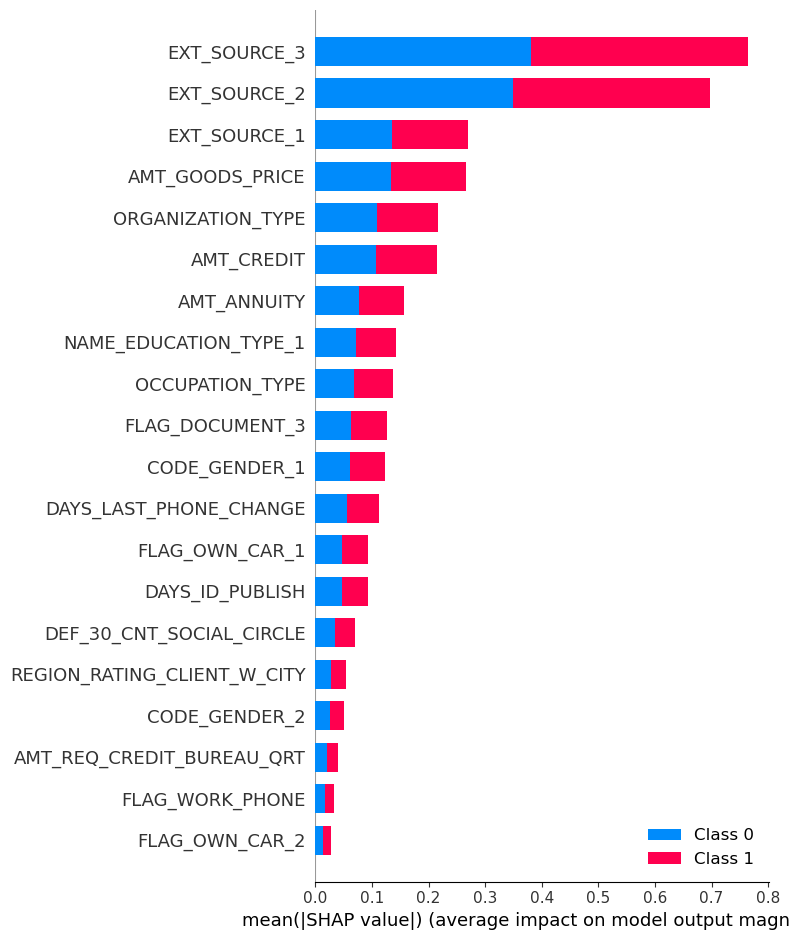

In [29]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


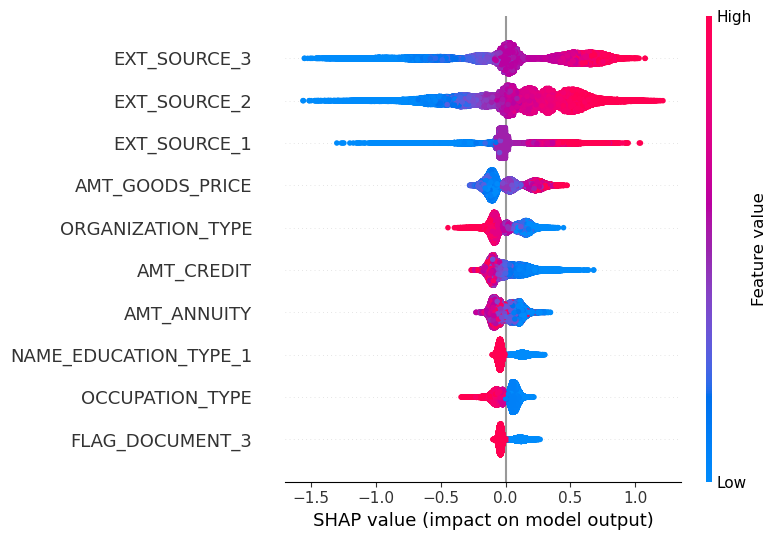

In [31]:
shap.summary_plot(shap_values[0], features=X_test, max_display=10)